### 아이리스 너비 길이 예측
- 데이터셋: iris.csv
- 피쳐: 3개
- 타겟: 1개
- 학습방법: 지도학습 >> 회귀
- 알고리즘: DNN (심층신경망)
- 프레임워크: pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchmetrics.regression import R2Score, MeanSquaredError
from torchinfo import summary

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split

In [2]:
# 모듈 버전 확인
def ver_check():
    print(f'torch v.{torch.__version__}')
    print(f'pandas v.{pd.__version__}')

In [3]:
ver_check()

torch v.2.4.1
pandas v.2.0.3


In [4]:
DATA_FILE = r'C:\Users\KDP-43\Desktop\머신러닝_1\data\iris.csv'

irisDF = pd.read_csv(DATA_FILE, usecols=[0,1,2,3])
irisDF.head(3)

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [5]:
# 타겟&피쳐 && train&valid&test 분리
targetDF = irisDF[['petal.width']]
# featureDF = irisDF.drop('petal.width', axis=1)
featureDF = irisDF[irisDF.columns[:-1]]

print(f'featureDF: {featureDF.shape} {featureDF.ndim}D')
print(f'targetDF: {targetDF.shape} {targetDF.ndim}D')

X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF,random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=10)

print()
print(f'X_trian: {X_train.shape} {X_train.ndim}D')
print(f'y_trian: {y_train.shape} {y_train.ndim}D')
print(f'X_val: {X_val.shape} {X_val.ndim}D')
print(f'y_val: {y_val.shape} {y_val.ndim}D')
print(f'X_test: {X_test.shape} {X_test.ndim}D')
print(f'y_test: {y_test.shape} {y_test.ndim}D')

featureDF: (150, 3) 2D
targetDF: (150, 1) 2D

X_trian: (84, 3) 2D
y_trian: (84, 1) 2D
X_val: (28, 3) 2D
y_val: (28, 1) 2D
X_test: (38, 3) 2D
y_test: (38, 1) 2D


#### 학습 모델 클래스 생성
- 클래스 목적: iris 피쳐 3개 학습 -> 너비 예측
- 클래스 이름: IrisRegModel
- 부모 클래스: nn.Module
- 매개 변수	: layer별 입출력 개수 고정이라 필요 X
- 기능/역할	: 
	* \___init___\(): 모델 구조 선언
	* forward()	: 순방향 학습		<= 오버라이딩
<br>
- 클래스 구조
	* 입력층:	입력 3개	출력 10		AF ReLU
	* 은닉층:	입력 10		출력 20		AF ReLU
	* 은닉층:	입력 20		출력 5 		AF ReLU
	* 출력층:	입력 5		출력 : 1개


In [6]:
class IrisRegModel(nn.Module):
    
	# 모델 인스턴스 생성 메서드
	def __init__(self):
		super().__init__()

		self.in_layer = nn.Linear(3, 10)
		self.hd_layer = nn.ModuleList([ nn.Linear(10, 20), nn.Linear(20, 5)])
		self.ot_layer = nn.Linear(5, 1)

		# self.in_layer = nn.Linear(3, 10)
		# self.hd_layer = nn.Linear(10, 20)
		# self.hd_layer = nn.Linear(20, 5)
		# self.ot_layer = nn.Linear(5, 1)

	# 순방향 학습 메서드
	def forward(self, data):

		x = F.relu(self.in_layer(data))

		for linear in self.hd_layer:
			x = F.relu( linear(x))


		# x = F.relu(self.in_layer(data))
		# x = F.relu(self.hd_layer(x))
		# x = F.relu(self.hd_layer(x))

		return self.ot_layer(x)


In [7]:
# [테스트] 학습 모델 인스턴스
model = IrisRegModel()

# print(model)
# print()
# summary(model, input_size=(150, 3))

#### 데이터셋 텐서화 클래스 생성
- 클래스이름: IrisDataset
- 클래스목적: iris train, val, test 텐서화
- 부모클래스: utils.data.Dataset
- 속성_필드: featureDF, targetDF, n_rows, n_features
- 필수메서드: 
	* - \___init___\(self): 데이터 저장 및 전처리, 개발자가 필요한 속성 설정
	* - len(self): 데이터 개수(길이) 반화
	* - getitem(self, idx): 특정 인덱스 피쳐 타겟 변환

In [8]:
class IrisDataset(Dataset):
    
	def __init__(self, featureDF, targetDF):

		# super.__init__()			# 왜 self error??
		self.featureDF = featureDF
		self.targetDF = targetDF
		self.n_rows = featureDF.shape[0]
		self.n_features = featureDF.shape[1]


	def __len__(self):
		return self.n_rows

	def __getitem__(self, idx):

		# 텐서화
		# DF->array->Tensor
		featureTS = torch.FloatTensor(self.featureDF.iloc[idx].values)
		targetTS = torch.FloatTensor(self.targetDF.iloc[idx].values)

		return featureTS, targetTS

In [9]:
## [테스트] 사용자 정의 데이터셋
trainDS = IrisDataset(X_train, y_train)

for data, label in trainDS:
    print(data, label)
    break


tensor([5.5000, 4.2000, 1.4000]) tensor([0.2000])


#### 학습준비

In [10]:
### 학습 진행 상수 설정
EPOCH = 1000
BATCH_SIZE = 10
BATCH_CNT = irisDF.shape[0] // BATCH_SIZE
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

LR = 0.001

In [11]:
trainDS = IrisDataset(X_train,y_train)
testDS = IrisDataset(X_test, y_test)
valDS = IrisDataset(X_val, y_val)

# 데이터로더 인스턴스
trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE)

In [12]:
## 데이터로더 체크
for featureTS, targetTS in trainDL:
    print(featureTS.shape, targetTS.shape)
    break

torch.Size([10, 3]) torch.Size([10, 1])


In [13]:
# 손실함수
regLoss= nn.MSELoss()
# 최적화 인스턴스
optimizer = optim.Adam(model.parameters(), lr=LR)

#### 학습진행
- train, val, test

In [14]:
# 모든 에포크에 대한 학습 후 모델 손실값 & 성능지표 저장 딕셔너리
LOSS_history = {'Train':[], 'Val':[]}
SCORE_history = {'Train':[], 'Val':[] }

for ep in range(EPOCH):
    
	# 학습 모드로 모델 설정
    model.train()
    
    loss_total=0
    score_total=0
    
    for featureTS, targetTS in trainDL:
        
        pre_y = model(featureTS)
        
        loss = regLoss(pre_y, targetTS)
        loss_total+=loss.item()
        
        score = R2Score()(pre_y, targetTS)
        score_total+=score.item()
        
		# 역전파 (weigt,bias 업데이트)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
	# 한 에포크에 대해 검증
    
	# 모델 검증모드 설정
    model.eval()
    
    with torch.no_grad():
        val_featTS = torch.FloatTensor(valDS.featureDF.values)
        val_targTS = torch.FloatTensor(valDS.targetDF.values)
        
        pre_val = model(val_featTS)
        
        loss_val = regLoss(pre_val, val_featTS)
        
        score_val = R2Score()(pre_val, val_targTS)
        
	# 한 에포크 학습 후 손실값&성능평가 저장
    
    LOSS_history['Train'].append(loss_total/BATCH_CNT)
    SCORE_history['Train'].append(score_total/BATCH_CNT)
        
    LOSS_history['Val'].append(loss_val)
    SCORE_history['Val'].append(score_val)
    
    if ep%50 ==0: 
        print(f"[{ep}/{EPOCH}]\n- [Train] LOSS: {LOSS_history['Train'][-1]:.5f} Score: {SCORE_history['Train'][-1]:.5f}")
        print(f"- [Valid] LOSS: {LOSS_history['Val'][-1]:.5f} Score: {SCORE_history['Val'][-1]:.5f}")
		
                



c:\Users\KDP-43\anaconda3\envs\torch_38\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([28, 3])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[0/1000]
- [Train] LOSS: 0.68465 Score: -1.25899
- [Valid] LOSS: 15.11915 Score: -0.59334
[50/1000]
- [Train] LOSS: 0.02155 Score: 0.54023
- [Valid] LOSS: 10.80233 Score: 0.89517
[100/1000]
- [Train] LOSS: 0.01937 Score: 0.54773
- [Valid] LOSS: 10.83497 Score: 0.89860
[150/1000]
- [Train] LOSS: 0.01837 Score: 0.55166
- [Valid] LOSS: 10.79076 Score: 0.90297
[200/1000]
- [Train] LOSS: 0.01782 Score: 0.55350
- [Valid] LOSS: 10.77654 Score: 0.90406
[250/1000]
- [Train] LOSS: 0.01739 Score: 0.55513
- [Valid] LOSS: 10.77470 Score: 0.90523
[300/1000]
- [Train] LOSS: 0.01712 Score: 0.55554
- [Valid] LOSS: 10.78392 Score: 0.90436
[350/1000]
- [Train] LOSS: 0.01646 Score: 0.55787
- [Valid] LOSS: 10.75542 Score: 0.90655
[400/1000]
- [Train] LOSS: 0.01608 Score: 0.55890
- [Valid] LOSS: 10.75269 Score: 0.90775
[450/1000]
- [Train] LOSS: 0.01585 Score: 0.56009
- [Valid] LOSS: 10.73026 Score: 0.90866
[500/1000]
- [Train] LOSS: 0.01539 Score: 0.56083
- [Valid] LOSS: 10.73671 Score: 0.90989
[550/1000]


Text(0.5, 1.0, 'R2-score')

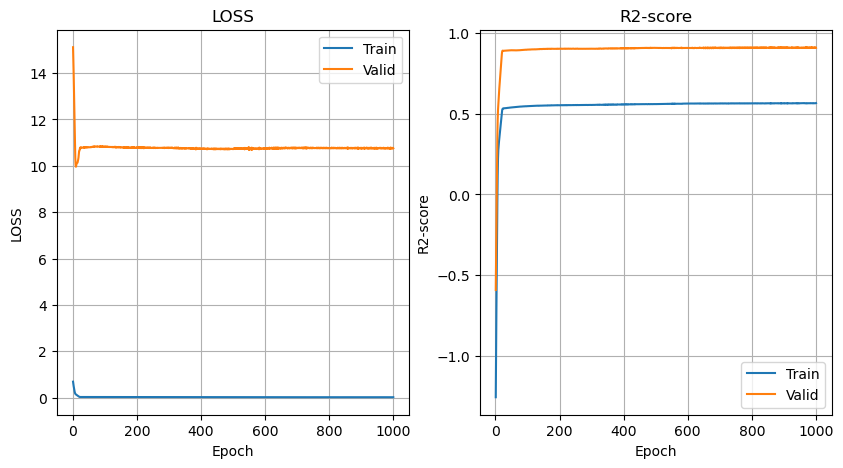

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(10,5))

axes[0].plot(range(1, EPOCH+1), LOSS_history['Train'],label="Train")
axes[0].plot(range(1, EPOCH+1), LOSS_history['Val'],label="Valid")
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("LOSS")
axes[0].set_title("LOSS")

axes[1].plot(range(1, EPOCH+1), SCORE_history['Train'],label="Train")
axes[1].plot(range(1, EPOCH+1), SCORE_history['Val'],label="Valid")
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("R2-score")
axes[1].set_title("R2-score")

R2Score가 높은데 loss는 10이상으로 매우 높은 결과


In [17]:
## test 데이터셋

test_featTS = torch.FloatTensor(testDS.featureDF.values)
test_targTS = torch.FloatTensor(testDS.targetDF.values)

pre_test = model(test_featTS)

print(f'[TEST]\nLOSS: {regLoss(pre_test, test_targTS):.5f} SCORE:{R2Score()(pre_test, test_targTS):.5f}')


[TEST]
LOSS: 0.03874 SCORE:0.92685
